# Overview

**[Predicting Heart Disease](https://www.kaggle.com/competitions/playground-series-s6e2/overview)**

Target은 Heart Disease

Learning Type: Binary Classification

Metric: Area under curve

In [1]:
import os
from pathlib import Path

In [2]:
data_path = Path('data')

if not os.path.exists(data_path / 'train.csv'):
    !kaggle competitions download -c playground-series-s6e2
    !unzip playground-series-s6e2.zip -d data
    !rm playground-series-s6e2.zip

In [3]:
import mllabs
mllabs.__version__

'0.3.0'

In [4]:
import polars as pl
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline

from mllabs import Experimenter, Connector
from mllabs.processor import PolarsLoader, PandasConverter
from mllabs.processor import CatConverter
from mllabs.collector import MetricCollector, ModelAttrCollector

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from IPython.display import Markdown

In [5]:
loader = make_pipeline(
    PolarsLoader(predefined_types={'id': pl.Int64}),
    PandasConverter(index_col='id')
)
train_file = data_path / 'train.csv'
test_file = data_path / 'test.csv'
df_train = loader.fit_transform([train_file])
df_data_spec = loader[0].df_type_.join(
    pd.Series(loader[0].pl_type_, name = 'actual_dtype')
)
df_data_spec

,min,max,na,count,n_unique,dtype,f32,i32,i16,i8,actual_dtype
feature,,,,,,,,,,,
Age,29.0,77.0,0.0,630000.0,42.0,Int64,True,True,True,True,Int8
BP,94.0,200.0,0.0,630000.0,66.0,Int64,True,True,True,False,Int16
Chest pain type,1.0,4.0,0.0,630000.0,4.0,Int64,True,True,True,True,Int8
Cholesterol,126.0,564.0,0.0,630000.0,150.0,Int64,True,True,True,False,Int16
EKG results,0.0,2.0,0.0,630000.0,3.0,Int64,True,True,True,True,Int8
Exercise angina,0.0,1.0,0.0,630000.0,2.0,Int64,True,True,True,True,Int8
FBS over 120,0.0,1.0,0.0,630000.0,2.0,Int64,True,True,True,True,Int8
Heart Disease,NaN,NaN,0.0,630000.0,2.0,String,False,False,False,False,Categorical
Max HR,71.0,202.0,0.0,630000.0,93.0,Int64,True,True,True,False,Int16


# Data Spec.

원본 데이터셋을 기반으로 Competition 용으로 인공적으로 생성한 데이터인데,

이 문제에 접근한 시점에서 원본 데이터가 올라온 페이지가

사라져서 정확한 스펙을 알수가 없다.

데이터에 대한 지식이 없어 GPT를 활용해서 대략의 스펙 조사.

변수의 대략의 스펙을 뽑아 보자.

In [6]:
print(df_data_spec.loc[:, ['min', 'max', 'n_unique', 'actual_dtype']].to_markdown())

| feature                 |   min |      max |   n_unique | actual_dtype   |
|:------------------------|------:|---------:|-----------:|:---------------|
| Age                     |    29 |     77   |         42 | Int8           |
| BP                      |    94 |    200   |         66 | Int16          |
| Chest pain type         |     1 |      4   |          4 | Int8           |
| Cholesterol             |   126 |    564   |        150 | Int16          |
| EKG results             |     0 |      2   |          3 | Int8           |
| Exercise angina         |     0 |      1   |          2 | Int8           |
| FBS over 120            |     0 |      1   |          2 | Int8           |
| Heart Disease           |   nan |    nan   |          2 | Categorical    |
| Max HR                  |    71 |    202   |         93 | Int16          |
| Number of vessels fluro |     0 |      3   |          4 | Int8           |
| ST depression           |     0 |      6.2 |         66 | Float32        |

## Type from GPT

| Feature                  | ML_Type      |
|--------------------------|-------------|
| Age                      | Numeric     |
| BP                       | Numeric     |
| Cholesterol              | Numeric     |
| Max HR                   | Numeric     |
| ST depression            | Numeric     |
| Chest pain type          | Categorical |
| EKG results              | Categorical |
| Exercise angina          | Categorical |
| FBS over 120             | Categorical |
| Sex                      | Categorical |
| Thallium                 | Categorical |
| Number of vessels fluro  | Ordinal     |
| Slope of ST              | Ordinal     |
| Heart Disease            | Target      |
| id                       | Identifier  |

**일단은 위 형식으로 따라가고, 타입 조정의 요소가 있을 때, 변경**

In [7]:
df_test = loader.transform([test_file])

Thallium 이 원소명이라 수치형으로 생각이 됐지만, GPT는 코드라고 응답했고,  범주형이라고 하여, 빈도 조사해 보자.

In [8]:
df_train['Thallium'].value_counts()

Thallium
3    372286
7    246748
6     10966
Name: count, dtype: int64

In [9]:
target = 'Heart Disease'
X_cont = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
X_nom = ['Chest pain type', 'EKG results', 'Thallium']
X_ord = ['Number of vessels fluro', 'Slope of ST']
X_bin = ['Exercise angina', 'FBS over 120', 'Sex']
X_all = X_cont + X_nom + X_ord + X_bin
print('Var. no', df_data_spec.shape[0])
print('Cont.', len(X_cont))
print('Nom.', len(X_nom))
print('Ord.', len(X_ord))
print('Bin.', len(X_bin))

Var. no 15
Cont. 5
Nom. 3
Ord. 2
Bin. 3


In [10]:
display(df_train.head(5))
df_train.shape

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
id,,,,,,,,,,,,,,
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


(630000, 14)

In [11]:
display(df_test.head(5))
df_test.shape

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
id,,,,,,,,,,,,,
630000,58,1,3,120,288,0,2,145,1,0.8,2,3,3
630001,55,0,2,120,209,0,0,172,0,0.0,1,0,3
630002,54,1,4,120,268,0,0,150,1,0.0,2,3,7
630003,44,0,3,112,177,0,0,168,0,0.9,1,0,3
630004,43,1,1,138,267,0,0,163,0,1.8,2,0,7


(270000, 13)

# 평가셋과 학습셋의 차이 파악

평가셋에 대한 정보가 딱히 없다. Train과 Test의 분포의 차이를 Train과 Test를 분류하는 모델을 만들어 살펴 보고,

피쳐의 특성을 파악할 때, Train과 Test의 분포 차이를 봐야 할 지를 정해 놓고, 속성별 파악을 하자.

In [12]:
df_is_test = pd.concat([
    df_train.drop(columns = [target]).assign(is_test=0),
    df_test.assign(is_test=1)
])
display(df_is_test.head())
df_is_test['is_test'].value_counts()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,is_test
id,,,,,,,,,,,,,,
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,0
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0
3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,0
4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,0


is_test
0    630000
1    270000
Name: count, dtype: int64

In [13]:
if os.path.exists('exp/is_test'):
    e_is_test = Experimenter.load('exp/is_test', df_is_test)
else:
    e_is_test = Experimenter.create(
        df_is_test, 'exp/is_test', title = 'Train/Test셋 여부를 구분', sp = StratifiedShuffleSplit(n_splits=1, random_state = 1), splitter_params = {'y': 'is_test'}
    )
    if e_is_test.status == 'closed':
        e_is_test.reopen_exp()
Markdown(
    e_is_test.desc_spec()
)

📁 Created directory: exp/is_test


## Train/Test셋 여부를 구분

| 항목 | 값 |
|------|-----|
| **Outer Splitter (sp)** | `StratifiedShuffleSplit(n_splits=1, random_state=1)` |
| **Inner Splitter (sp_v)** | None |
| **Splitter Params** | `{y='is_test'}` |
| **Outer Folds** | 1 |
| **Inner Folds** | 1 |

In [14]:
import lightgbm as lgb
e_is_test.add_collector(
    MetricCollector(
        'AUC', Connector(edges = {'y': [(None, 'is_test')]}), slice(-1, None), roc_auc_score, include_train = True
    )
)
e_is_test.add_collector(
    ModelAttrCollector(
        'lgb_feature_importance', Connector(processor = lgb.LGBMClassifier), 'feature_importances'
    )
)
e_is_test.set_grp('clf', role = 'head', edges = {'y': [(None, 'is_test')]}, method = 'predict_proba')
e_is_test.set_node(
    'lgb1', grp='clf', processor=lgb.LGBMClassifier , edges = {'X': [(None, X_all)]}, 
    params={'verbose': -1, 'categorical_features': X_nom}
)

Collect 1/1 (100%) Node 0
Collect 1/1 (100%) Node 0


{'result': 'new',
 'affected_nodes': [],
 'old_obj': None,
 'obj': <mllabs._pipeline.PipelineNode at 0x7f422f98fd70>}

In [15]:
e_is_test.exp()

Experimenting 1 node(s)
Exp 0/1 (0%) > Node 0/1 (0%)[lgb1] Exp error at fold 0: LightGBMError: categorical_feature is not a number,
if you want to use a column name,
please add the prefix "name:" to the column name
Exp 1/1 (100%) lgb1 1/1 (100%)
Experimentation complete: 0/1 node(s), 1 error(s): ['lgb1']


[LightGBM] [Fatal] categorical_feature is not a number,
if you want to use a column name,
please add the prefix "name:" to the column name


In [16]:
e_is_test.show_error_nodes()

[lgb1] LightGBMError: categorical_feature is not a number,
if you want to use a column name,
please add the prefix "name:" to the column name


LGBMClassifier에 categorical_feature에 수치형 타입을 쓸 수 없으니, 범주형으로 변환하는 과정을 적용합니다.

In [17]:
e_is_test.set_grp('pre', role = 'stage', method = 'transform')

{'result': 'new',
 'grp': <mllabs._pipeline.PipelineGroup at 0x7f422f990560>,
 'affected_nodes': []}

In [21]:
e_is_test.set_node(
    'n2c', grp='pre', processor=CatConverter, edges = {'X': [(None, X_nom)]}
)

{'result': 'new',
 'affected_nodes': [],
 'old_obj': None,
 'obj': <mllabs._pipeline.PipelineNode at 0x7f422da9ee40>}

In [22]:
e_is_test.set_node(
    'lgb1', grp='clf', processor=lgb.LGBMClassifier , edges = {'X': [(None, X_cont + X_bin), ('n2c', None)]}, 
    params={'verbose': -1, 'categorical_features': ['n2c__' + i for i in X_nom]}, method = 'predict_proba', exist = 'replace'
)

{'result': 'update',
 'affected_nodes': [],
 'old_obj': <mllabs._pipeline.PipelineNode at 0x7f422f98fd70>,
 'obj': <mllabs._pipeline.PipelineNode at 0x7f422daa0110>}

In [23]:
Markdown(
    e_is_test.desc_pipeline()
)

```mermaid
graph TD

    DataSource([DataSource])
    style DataSource fill:#fff9c4,stroke:#f57c00,stroke-width:3px

    subgraph grp_clf["clf"]
        node_lgb1["lgb1"]
        style node_lgb1 fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
    end
    style grp_clf fill:#e3f2fd,stroke:#1976d2,stroke-width:2px

    subgraph grp_pre["pre"]
        node_n2c["n2c"]
        style node_n2c fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
    end
    style grp_pre fill:#e3f2fd,stroke:#1976d2,stroke-width:2px

    DataSource --> grp_clf
    DataSource --> grp_pre
    grp_pre --> grp_clf
```

In [24]:
Markdown(
    e_is_test.desc_node('lgb1', show_params=True)
)

```mermaid
graph TD

    DataSource([DataSource])
    style DataSource fill:#fff9c4,stroke:#f57c00,stroke-width:3px

    subgraph node_lgb1["clf/lgb1"]
        lgb1_info["<table><tr><td align='left'><b>processor</b></td><td align='left'>LGBMClassifier</td></tr><tr><td align='left'><b>method</b></td><td align='left'>predict_proba</td></tr><tr><td align='left'><b>verbose</b></td><td align='left'>-1</td></tr><tr><td align='left'><b>categorical_features</b></td><td align='left'>['n2c__Chest pain type', 'n2c__EKG re...</td></tr></table>"]
    end
    style node_lgb1 fill:#ffcdd2,stroke:#c62828,stroke-width:3px

    subgraph node_n2c["pre/n2c"]
        n2c_info["<table><tr><td align='left'><b>processor</b></td><td align='left'>CatConverter</td></tr><tr><td align='left'><b>method</b></td><td align='left'>transform</td></tr></table>"]
    end
    style node_n2c fill:#c8e6c9,stroke:#388e3c,stroke-width:2px

    DataSource -->|X,y| node_lgb1
    DataSource --> node_n2c
    node_n2c --> node_lgb1
```

**Path from DataSource to 'clf/lgb1' (2 path(s) found)**

### Edges

| Key | Node | Var |
|-----|------|-----|
| X | Data Source | `['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression', 'Exercise angina', 'FBS over 120', 'Sex']` |
| X | pre/n2c | * |
| y | Data Source | `is_test` |

In [25]:
e_is_test.build()

Building 1 node(s)
Build 1/1 (100%) n2c 1/1 (100%)
Build complete: 1 node(s)


In [26]:
e_is_test.exp()

Experimenting 1 node(s)
Exp 1/1 (100%) lgb1 1/1 (100%) 100/100 (100%)
Experimentation complete: 1 node(s)


In [27]:
e_is_test.get_obj_vars('lgb1', 0)

[(['Age',
   'BP',
   'Cholesterol',
   'Max HR',
   'ST depression',
   'Exercise angina',
   'FBS over 120',
   'Sex',
   'n2c__Chest pain type',
   'n2c__EKG results',
   'n2c__Thallium'],
  ['lgb1__is_test_0', 'lgb1__is_test_1'],
  [0])]

In [28]:
e_is_test.collectors['AUC'].get_metrics_agg(None)[0]

,valid,train_sub
lgb1,0.503313,0.542511


In [29]:
from mllabs import ColSelector

In [30]:
e_is_test.set_node(
    'lgb2', grp='clf', processor=lgb.LGBMClassifier , edges = {'X': [(None, X_cont + X_bin), ('n2c', None)]}, 
    params={'verbose': -1, 'categorical_features': ColSelector(col_type = 'category'), 'n_estimators': 1000}, method = 'predict_proba'
)
e_is_test.exp()

Experimenting 1 node(s)
Exp 1/1 (100%) lgb2 1/1 (100%) 1000/1000 (100%)
Experimentation complete: 1 node(s)


In [31]:
e_is_test.pipeline.compare_nodes(
    e_is_test.pipeline.get_node_names('lgb*')
)['LGBMClassifier'].fillna('default').join(
    e_is_test.collectors['AUC'].get_metrics_agg(None)[0].stack().rename('AUC').to_frame().unstack()
)

params               \
                                   categorical_features n_estimators   
lgb1  [n2c__Chest pain type, n2c__EKG results, n2c__...      default   
lgb2  <mllabs._pipeline.ColSelector object at 0x7f42...       1000.0   

           AUC            
         valid train_sub  
lgb1  0.503313  0.542511  
lgb2  0.504157  0.638938

In [32]:
e_is_test.close_exp()

Finalize 'n2c'
Finalize 'lgb1'
Finalize 'lgb2'


입력 속성으로 LGBMClassifier로 Train과 Test를 구분하는 모델을 만든 결과

Train과 Test를 구분하기에는 어렵다는 것을 확인할 수 있었습니다.

따라서 Train과 Test의 입력 Feature의 차이점 분석은 유의미한 정보를 얻을 가능성은 적습니다.

우선 순위를 미루고, score상 Validation 결과와 차이가 크다면, 분석을 고려합니다.

여기서 LGBM에서의 feature importance는 의미는 없지만, 기능을 보이기 위해 참고적으로 출력합니다.

In [33]:
e_is_test.collectors['lgb_feature_importance'].get_attrs()['lgb2']

[[Age                     5085
  BP                      4413
  Cholesterol             6503
  Max HR                  5869
  ST depression           3974
  Exercise angina          701
  FBS over 120             366
  Sex                      678
  n2c__Chest pain type     546
  n2c__EKG results         940
  n2c__Thallium            925
  Name: importance, dtype: int32]]

# Exploratory Data Analysis

## Target: Heart Disease

In [34]:
df_train[target].value_counts().pipe(
    lambda x: pd.concat([x, (x / x.sum()).rename('ratio')], axis=1)
)

,count,ratio
Heart Disease,,
Absence,347546,0.55166
Presence,282454,0.44834


Absence(55.2%) vs Presence(44.8%)로 약한 불균형. Stratified split으로 대응 가능하며 별도의 imbalance 처리는 우선 불필요.

## Continuous Variable

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
X_cont

['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']

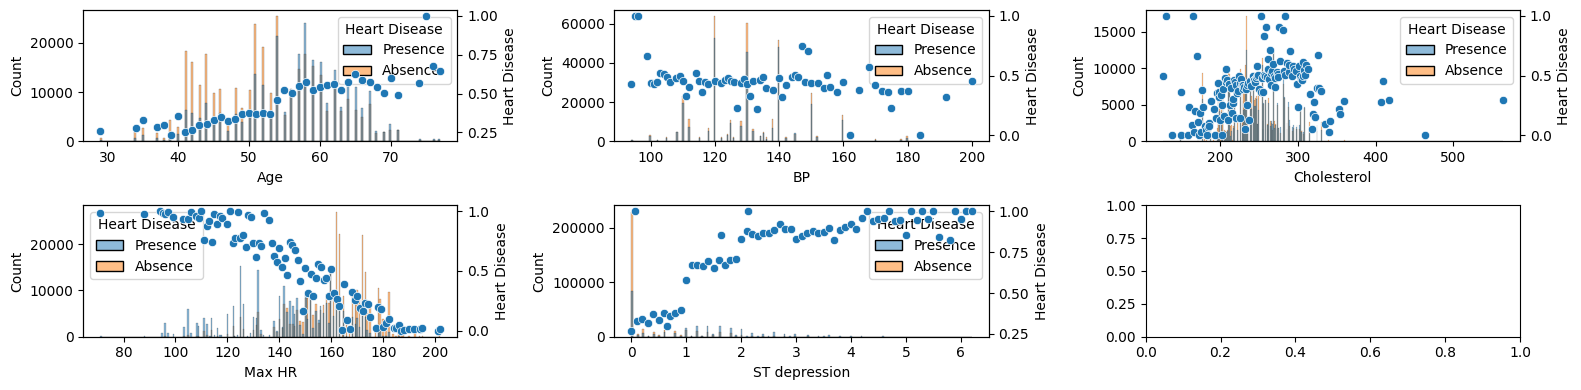

In [37]:
_, axes = plt.subplots(2, 3, figsize = (16, 4))
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_train, x = i, ax = ax, hue = target)
    df_train.groupby(i)[target].agg(lambda x: (x == 'Presence').mean()).to_frame().pipe(
        lambda x: sns.scatterplot(x, x = i, y = target, ax = ax.twinx())
    )
plt.tight_layout()
plt.show()

In [38]:
from sklearn.metrics import roc_auc_score

df_train[X_cont].apply(
    lambda x: roc_auc_score(df_train[target], x)
).apply(
    lambda x: max(x, 1 - x)
).rename('AUC').sort_values(ascending = False).to_frame().T

,Max HR,ST depression,Age,Cholesterol,BP
AUC,0.755908,0.733678,0.625654,0.552904,0.500486


Max HR(0.756), ST depression(0.734)이 단독 예측력 1~2위. Age, Cholesterol은 중간 수준. BP(0.500)는 단독으로는 사실상 무의미.

In [39]:
df_train[X_cont].corr(method='spearman').unstack().rename('corr').reset_index().query('level_0 < level_1').pipe(
    lambda x: x.iloc[np.argsort(-x['corr'].abs())]
)

,level_0,level_1,corr
19,Max HR,ST depression,-0.231181
4,Age,ST depression,0.106459
3,Age,Max HR,-0.099570
13,Cholesterol,Max HR,-0.053541
14,Cholesterol,ST depression,0.048520
2,Age,Cholesterol,0.022749
7,BP,Cholesterol,-0.003558
1,Age,BP,-0.002731
8,BP,Max HR,0.001367
9,BP,ST depression,-0.001015


연속형 변수 간 상관관계는 전반적으로 낮음(최대 -0.231). 다중공선성 우려는 적으며 변수 간 독립성이 높은 편.

In [40]:
df_st_freq = pd.concat([
    df_train['ST depression'].value_counts(),
    df_train.groupby(i)[target].agg(lambda x: (x == 'Presence').mean())
], axis=1)
df_st_freq

,count,Heart Disease
ST depression,,
0.00,314939,0.269332
1.20,29269,0.668591
1.00,28647,0.581492
1.60,28395,0.701215
1.40,27146,0.697561
...,...,...
4.70,4,1.000000
5.10,2,1.000000
2.12,1,1.000000


In [41]:
from scipy.stats import spearmanr
spearmanr(df_st_freq['count'], df_st_freq[target])

SignificanceResult(statistic=np.float64(-0.6640987899506298), pvalue=np.float64(1.2118203419747983e-09))

ST depression 값의 빈도와 Heart Disease 비율 간 강한 음의 상관(ρ=-0.664, p≈0). 빈도가 낮은(희귀한) 값일수록 Heart Disease 비율이 높음. 수치형 그대로 활용 가능.

## Categorical Variables

In [42]:
df_train[X_bin + X_ord + X_nom].nunique().rename('n_unique').to_frame().T

,Exercise angina,FBS over 120,Sex,Number of vessels fluro,Slope of ST,Chest pain type,EKG results,Thallium
n_unique,2,2,2,4,3,4,3,3


### Chi2-Test

In [43]:
from scipy.stats import chi2_contingency

df_train[X_bin + X_ord + X_nom].apply(
    lambda x: chi2_contingency(pd.crosstab(index = x, columns = df_train[target]))[1]
).sort_values(ascending = True)

Exercise angina             0.000000e+00
Sex                         0.000000e+00
Number of vessels fluro     0.000000e+00
Slope of ST                 0.000000e+00
EKG results                 0.000000e+00
Chest pain type             0.000000e+00
Thallium                    0.000000e+00
FBS over 120               2.280820e-156
dtype: float64

모든 범주형 변수가 Target과 유의미한 연관성(p≈0). FBS over 120만 상대적으로 p값이 높아 예측력이 약함.

### Information gain

In [44]:
y_prob = df_train[target].value_counts(normalize = True)
H_target = -y_prob.dot(np.log(y_prob))

pd.Series({
    i: H_target - pd.crosstab(index = df_train[i], columns = df_train[target], normalize = 'index').apply(
        lambda x: -x.dot(np.log(x)), axis = 1
    ).dot(df_train[i].value_counts(normalize = True)) for i in X_bin + X_ord + X_nom
}, name = 'IG').sort_values(ascending = False)

Thallium                   0.195539
Chest pain type            0.146677
Number of vessels fluro    0.114068
Exercise angina            0.101636
Slope of ST                0.094895
Sex                        0.062929
EKG results                0.024196
FBS over 120               0.000561
Name: IG, dtype: float64

IG 순위: Thallium(0.196) > Chest pain type(0.147) > Number of vessels fluro(0.114) > Exercise angina(0.102) > Slope of ST(0.095) > Sex(0.063) > EKG results(0.024) > FBS over 120(0.001)

FBS over 120은 IG 0.001로 단독 예측력은 낮음. 단, Feature Interaction이나 실험을 통해 유효성 여부를 추가 검토.

### Oridnal Variables

In [45]:
df_train.groupby('Number of vessels fluro')[target].agg(lambda x: (x == 'Presence').mean())

Number of vessels fluro
0    0.303132
1    0.729346
2    0.897078
3    0.899549
Name: Heart Disease, dtype: float64

0→1→2→3으로 Heart Disease 비율이 0.303→0.729→0.897→0.900으로 단조 증가. 2와 3의 차이가 미미하여 수치형으로 활용 가능.

In [46]:
df_train.groupby('Slope of ST')[target].agg(lambda x: (x == 'Presence').mean())

Slope of ST
1    0.262257
2    0.692067
3    0.721082
Name: Heart Disease, dtype: float64

1→2→3으로 Heart Disease 비율이 0.262→0.692→0.721. 1→2 전환이 크고 2→3은 미미. 수치형으로 활용 가능하며 2와 3의 병합도 고려 가능.

### Nominal Variables

In [47]:
df_train.groupby('Thallium')[target].agg(lambda x: (x == 'Presence').mean())

Thallium
3    0.198049
6    0.686394
7    0.815391
Name: Heart Disease, dtype: float64

3(0.198) → 6(0.686) → 7(0.815)로 Heart Disease 비율 급증. IG 1위답게 변별력이 가장 높음. 단, 6의 빈도가 1.7%로 낮아 OOV 처리 시 주의.

In [48]:
df_train.groupby('Chest pain type')[target].agg(lambda x: (x == 'Presence').mean())

Chest pain type
1    0.108069
2    0.162181
3    0.190665
4    0.697478
Name: Heart Disease, dtype: float64

type 4(0.697)와 나머지(1: 0.108, 2: 0.162, 3: 0.191) 간 큰 격차. type 1/2/3은 유사한 수준으로 이진화(type 4 vs 나머지)도 유효한 선택.

In [49]:
df_train.groupby('EKG results')[target].agg(lambda x: (x == 'Presence').mean())

EKG results
0    0.341498
1    0.360061
2    0.559560
Name: Heart Disease, dtype: float64

0(0.341)과 1(0.360)은 거의 동일, 2(0.560)만 다소 높음. 전반적 변별력은 낮은 편.

## Binary Variables

In [50]:
df_train.groupby('Exercise angina')[target].agg(lambda x: (x == 'Presence').mean())

Exercise angina
0    0.313433
1    0.806288
Name: Heart Disease, dtype: float64

운동 유발 협심증 있음(1): 0.806 vs 없음(0): 0.313. 이진 변수 중 가장 강한 예측력.

In [51]:
df_train.groupby('Sex')[target].agg(lambda x: (x == 'Presence').mean())

Sex
0    0.178764
1    0.555933
Name: Heart Disease, dtype: float64

남성(1): 0.556 vs 여성(0): 0.179. 유의미한 차이.

In [52]:
df_train.groupby('FBS over 120')[target].agg(lambda x: (x == 'Presence').mean())

FBS over 120
0    0.443417
1    0.504961
Name: Heart Disease, dtype: float64

FBS over 120 여부에 따른 차이 미미(0.444 vs 0.505). 단독 예측력은 낮으나 다른 변수와의 Interaction 가능성은 열어둠.

## Chi2-test of each pair of variables

In [53]:
from itertools import combinations

In [54]:
pd.DataFrame(
    pd.Series(
        [
            a, b, 
            chi2_contingency(
                pd.crosstab(index = df_train[a], columns = df_train[b])
            )[1]
        ], index = ['V1', 'V2', 'p-value']
    ) for a, b in combinations(X_nom + X_ord + X_bin, 2)
).sort_values('p-value')

,V1,V2,p-value
0,Chest pain type,EKG results,0.000000e+00
1,Chest pain type,Thallium,0.000000e+00
2,Chest pain type,Number of vessels fluro,0.000000e+00
3,Chest pain type,Slope of ST,0.000000e+00
4,Chest pain type,Exercise angina,0.000000e+00
6,Chest pain type,Sex,0.000000e+00
7,EKG results,Thallium,0.000000e+00
8,EKG results,Number of vessels fluro,0.000000e+00
14,Thallium,Slope of ST,0.000000e+00
9,EKG results,Slope of ST,0.000000e+00


FBS over 120이 다른 변수들과 상대적으로 높은 p값을 보이며, 나머지 변수들 간에는 강한 연관성이 존재. 상호작용 파생변수 생성의 여지가 있음.

### Kruskal with Cont. variables

In [55]:
from scipy.stats import kruskal
from itertools import product

df_kruskal = pd.DataFrame(
    pd.Series(
        [
            a, b, 
            kruskal(*df_train.groupby(a)[b].agg(list)).pvalue
        ], index = ['V1', 'V2', 'p-value']
    ) for a, b in product(X_nom + X_ord + X_bin, X_cont)
).sort_values('p-value')

In [56]:
df_kruskal.iloc[:20]

,V1,V2,p-value
0,Chest pain type,Age,0.0
2,Chest pain type,Cholesterol,0.0
3,Chest pain type,Max HR,0.0
4,Chest pain type,ST depression,0.0
5,EKG results,Age,0.0
10,Thallium,Age,0.0
9,EKG results,ST depression,0.0
8,EKG results,Max HR,0.0
14,Thallium,ST depression,0.0
13,Thallium,Max HR,0.0


대부분의 범주형-연속형 변수 쌍에서 유의미한 연관성(p=0). BP만 상대적으로 약한 연관성을 보임.

In [57]:
for a, b in product(X_nom + X_ord + X_bin, X_cont):
    print(df_train.groupby(a)[b].agg(list))
    break

Chest pain type
1    [52, 53, 49, 57, 45, 54, 45, 41, 48, 65, 62, 5...
2    [56, 41, 52, 50, 48, 42, 55, 57, 42, 50, 47, 5...
3    [44, 60, 41, 44, 46, 65, 57, 52, 42, 54, 56, 3...
4    [58, 58, 38, 59, 48, 44, 42, 56, 65, 62, 66, 5...
Name: Age, dtype: object


## EDA 소결

| 구분 | 변수 |
|------|------|
| **예측력 상위** | Thallium, Chest pain type, Number of vessels fluro, Exercise angina, Max HR, ST depression |
| **예측력 중간** | Slope of ST, Sex, Age, Cholesterol |
| **예측력 하위** | EKG results, BP, FBS over 120 |

- 순서형 변수(Number of vessels fluro, Slope of ST)는 단조 증가 패턴 → 수치형 활용 가능
- 연속형 변수 간 공선성은 낮으나, 범주형 변수끼리 및 범주형-연속형 간에는 높은 연관성 존재 → 다중공선성 고려 필요
- 변수 간 강한 연관성이 있어 상호작용 파생변수 생성 여지 있음

### OOV 확인 (Train → Test)

CategoricalConverter는 OOV 처리 기능이 없음. Test에 Train에 없는 범주가 있으면 CatOOVFilter로 대응.

In [58]:
pd.concat([
    df_test[X_nom].apply(set, axis=0).rename('test'),
    df_train[X_nom].apply(set, axis=0).rename('train')
], axis=1).apply(lambda x: x['test'] - x['train'], axis=1)

Chest pain type    {}
EKG results        {}
Thallium           {}
dtype: object

## Analysis through ML

In [12]:
if os.path.exists('exp/analysis'):
    e_aml = Experimenter.load('exp/analysis', df_train)
    if e_aml.status == 'closed':
        e_aml.reopen_exp()
else:
    e_aml = Experimenter.create(
        df_train, 'exp/analysis', title='데이터 탐색을 위한 ML 실험',
        sp=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1),
        sp_v=StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=1),
        splitter_params={'y': target}
    )
Markdown(
    e_aml.desc_spec()
)

Loaded: 22 node(s), 6 group(s), 1 fold(s)


## 데이터 탐색을 위한 ML 실험

| 항목 | 값 |
|------|-----|
| **Outer Splitter (sp)** | `StratifiedShuffleSplit(n_splits=1, random_state=1, test_size=0.2)` |
| **Inner Splitter (sp_v)** | `StratifiedShuffleSplit(n_splits=1, random_state=1, test_size=0.1)` |
| **Splitter Params** | `{y='Heart Disease'}` |
| **Outer Folds** | 1 |
| **Inner Folds** | 1 |

In [13]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from lightgbm import early_stopping as lgb_early_stopping
from sklearn.linear_model import LogisticRegression
from mllabs.adapter import XGBoostAdapter, LightGBMAdapter, CatBoostAdapter

In [14]:
e_aml.set_grp('pre', role='stage', method='transform')
e_aml.set_node(
    'n2c', grp='pre', processor=CatConverter,
    edges={'X': [(None, X_nom)]}
)

e_aml.set_node(
    'lbl', grp='pre', processor=LabelEncoder,
    edges={'y': [(None, target)]}
)

e_aml.set_grp(
    'clf', role='head', method='predict_proba',
    edges={'y': [('lbl', None)]}
)


{'result': 'skip',
 'grp': <mllabs._pipeline.PipelineGroup at 0x7f175a5e79e0>,
 'affected_nodes': []}

In [15]:
# XGBoost
e_aml.set_grp('xgb', parent='clf', processor=xgb.XGBClassifier,
    adapter=XGBoostAdapter(eval_mode='valid'),
    params={
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'early_stopping_rounds': 50,
        'eval_metric': 'auc',
        'enable_categorical': True,
        'verbosity': 0,
        'random_state': 1,
    }
)

# LightGBM
e_aml.set_grp('lgb', parent='clf', processor=lgb.LGBMClassifier,
    adapter=LightGBMAdapter(eval_mode='valid'),
    params={
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'early_stopping': lgb_early_stopping(50, first_metric_only=True),
        'eval_metric': 'auc',
        'verbose': -1,
        'random_state': 1,
    }
)

# CatBoost
e_aml.set_grp('cb', parent='clf', processor=cb.CatBoostClassifier,
    adapter=CatBoostAdapter(eval_mode='valid'),
    params={
        'iterations': 1000,
        'learning_rate': 0.05,
        'early_stopping_rounds': 50,
        'eval_metric': 'AUC',
        'verbose': 0,
        'random_state': 1,
    }
)

# LogisticRegression (coef 분석용)
e_aml.set_grp('lr', parent='clf', processor=LogisticRegression,
    params={
        'max_iter': 1000,
        'random_state': 1,
    }
)

{'result': 'skip',
 'grp': <mllabs._pipeline.PipelineGroup at 0x7f175a5e7bf0>,
 'affected_nodes': []}

In [16]:
from mllabs.collector import SHAPCollector
from mllabs.filter import RandomFilter

# AUC metric — y edges 조건으로 clf 하위 노드에만 매칭
e_aml.add_collector(
    MetricCollector(
        'AUC',
        Connector(edges={'y': [('lbl', None)]}),
        slice(-1, None),
        roc_auc_score,
        include_train = True
    )
)

# Feature importance — LGB
e_aml.add_collector(
    ModelAttrCollector(
        'lgb_feature_importance',
        Connector(processor=lgb.LGBMClassifier, edges={'y': [('lbl', None)]}),
        'feature_importances'
    )
)

# Feature importance — XGB
e_aml.add_collector(
    ModelAttrCollector(
        'xgb_feature_importance_gain',
        Connector(processor=xgb.XGBClassifier, edges={'y': [('lbl', None)]}),
        'feature_importances', params = {'importance_type': 'gain'}
    )
)

e_aml.add_collector(
    ModelAttrCollector(
        'xgb_feature_importance_cover',
        Connector(processor=xgb.XGBClassifier, edges={'y': [('lbl', None)]}),
        'feature_importances', params = {'importance_type': 'cover'}
    )
)

# CatBoost feature importance (PredictionValuesChange)
e_aml.add_collector(
    ModelAttrCollector(
        'cb_feature_importance',
        Connector(processor=cb.CatBoostClassifier, edges={'y': [('lbl', None)]}),
        'feature_importances_pvc'
    )
)

# CatBoost feature interaction importance
e_aml.add_collector(
    ModelAttrCollector(
        'cb_interaction',
        Connector(processor=cb.CatBoostClassifier, edges={'y': [('lbl', None)]}),
        'feature_importances_interaction'
    )
)

# LogisticRegression coef
e_aml.add_collector(
    ModelAttrCollector(
        'lr_coef',
        Connector(processor=LogisticRegression, edges={'y': [('lbl', None)]}),
        'coef'
    )
)

# SHAP — XGB 전용, 10% random sample
e_aml.add_collector(
    SHAPCollector(
        'shap',
        Connector(processor=xgb.XGBClassifier, edges={'y': [('lbl', None)]}),
        data_filter=RandomFilter(frac=0.1, random_state=1)
    )
)

In [17]:
e_aml.set_node('xgb1', grp='xgb', edges={'X': [(None, X_all)]})
e_aml.set_node('lgb1', grp='lgb', edges={'X': [(None, X_all)]})
e_aml.set_node('cb1', grp='cb', edges={'X': [(None, X_all)]})

{'result': 'skip',
 'affected_nodes': [],
 'old_obj': <mllabs._pipeline.PipelineNode at 0x7f175a509c10>,
 'obj': <mllabs._pipeline.PipelineNode at 0x7f175a509c10>}

In [18]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from mllabs.col import ohe_drop_first

# OHE: X_nom + X_ord 가변수화
e_aml.set_node(
    'ohe', grp='pre', processor=OneHotEncoder,
    edges={'X': [(None, X_nom + X_ord)]},
    params={'sparse_output': False}
)

# StandardScaler: 연속형 표준화
e_aml.set_node(
    'std', grp='pre', processor=StandardScaler,
    edges={'X': [(None, X_cont)]}
)

# lr1: std 전체 + ohe drop-first (다중공선성 제거)
e_aml.set_node(
    'lr1', grp='lr',
    edges={'X': [('std', None), ('ohe', ohe_drop_first)]}
)

Markdown(e_aml.desc_pipeline(direction = 'LR', max_depth=2))

```mermaid
graph LR

    DataSource([DataSource])
    style DataSource fill:#fff9c4,stroke:#f57c00,stroke-width:3px

    subgraph grp_pre["pre"]
        node_n2c["n2c"]
        style node_n2c fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        node_lbl["lbl"]
        style node_lbl fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        node_ohe["ohe"]
        style node_ohe fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        node_std["std"]
        style node_std fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        node_freq_st["freq_st"]
        style node_freq_st fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        node_cat_pair["cat_pair"]
        style node_cat_pair fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        node_cont_inter["cont_inter"]
        style node_cont_inter fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        node_ohe_pair["ohe_pair"]
        style node_ohe_pair fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        node_std_cont_inter["std_cont_inter"]
        style node_std_cont_inter fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
    end
    style grp_pre fill:#e3f2fd,stroke:#1976d2,stroke-width:2px

    subgraph grp_clf["clf"]
        subgraph grp_xgb["xgb"]
            grp_xgb_count["5 node(s)"]
            style grp_xgb_count fill:#f5f5f5,stroke:#9e9e9e,stroke-dasharray: 5 5
        end
        style grp_xgb fill:#e3f2fd,stroke:#1976d2,stroke-width:2px
        subgraph grp_lgb["lgb"]
            grp_lgb_count["3 node(s)"]
            style grp_lgb_count fill:#f5f5f5,stroke:#9e9e9e,stroke-dasharray: 5 5
        end
        style grp_lgb fill:#e3f2fd,stroke:#1976d2,stroke-width:2px
        subgraph grp_cb["cb"]
            grp_cb_count["2 node(s)"]
            style grp_cb_count fill:#f5f5f5,stroke:#9e9e9e,stroke-dasharray: 5 5
        end
        style grp_cb fill:#e3f2fd,stroke:#1976d2,stroke-width:2px
        subgraph grp_lr["lr"]
            grp_lr_count["3 node(s)"]
            style grp_lr_count fill:#f5f5f5,stroke:#9e9e9e,stroke-dasharray: 5 5
        end
        style grp_lr fill:#e3f2fd,stroke:#1976d2,stroke-width:2px
    end
    style grp_clf fill:#e3f2fd,stroke:#1976d2,stroke-width:2px

    DataSource --> grp_clf
    DataSource --> grp_pre
    grp_pre --> grp_clf
```

In [19]:
e_aml.build()

Building 0 node(s)
Build 1/1 (100%) Node 0
Build complete: 0 node(s)


In [20]:
e_aml.exp()

Experimenting 0 node(s)
Exp 1/1 (100%) Node 0
Experimentation complete: 0 node(s)


In [21]:
e_aml.show_error_nodes()

No error nodes found


In [22]:
e_aml.collectors['AUC'].get_metrics_agg()[0].sort_values('valid', ascending = False)

,valid,train_sub,valid_sub
cb1,0.955224,0.956834,0.956806
xgb1,0.954915,0.958066,0.956418
xgb_freq,0.954906,0.958477,0.956405
lgb1,0.954899,0.958201,0.956518
xgb_cat,0.954893,0.958117,0.956490
lgb_cat,0.954890,0.957568,0.956399
lgb_all_fe,0.954839,0.958407,0.956436
xgb_cont,0.954825,0.958233,0.956314
xgb_all_fe,0.954811,0.958360,0.956428
lr3,0.950505,0.950816,0.951911


### Feature Importance

In [23]:
e_aml.collectors['lgb_feature_importance'].get_attrs_agg('lgb1').sort_values(ascending = False)

Max HR                     4428.0
Cholesterol                3087.0
Age                        2645.0
BP                         1942.0
ST depression              1757.0
Chest pain type             969.0
Number of vessels fluro     905.0
Slope of ST                 561.0
Thallium                    556.0
Exercise angina             535.0
Sex                         514.0
EKG results                 465.0
FBS over 120                146.0
dtype: float64

In [24]:
e_aml.collectors['xgb_feature_importance_gain'].get_attrs_agg('xgb1').sort_values(ascending = False)

Thallium                   2231.968018
Chest pain type             461.444977
Slope of ST                 225.249557
Number of vessels fluro     194.253983
Exercise angina             174.765350
Sex                         124.964325
ST depression                67.373009
Max HR                       60.908916
EKG results                  38.991219
Age                          17.406219
Cholesterol                   6.234970
BP                            4.276025
FBS over 120                  3.454225
dtype: float64

In [25]:
e_aml.collectors['xgb_feature_importance_cover'].get_attrs_agg('xgb1').sort_values(ascending = False)

Thallium                   7002.137207
Slope of ST                6163.359375
Max HR                     6106.077637
Chest pain type            5972.896973
Sex                        5900.744141
Exercise angina            5434.621582
Number of vessels fluro    5353.713867
EKG results                4874.784668
Cholesterol                4319.709473
BP                         4211.907715
ST depression              3249.057617
FBS over 120               3130.925781
Age                        2821.172852
dtype: float64

In [26]:
e_aml.collectors['cb_feature_importance'].get_attrs_agg('cb1').sort_values(ascending = False)

Max HR                     21.077985
Thallium                   17.935973
Chest pain type            16.592764
Number of vessels fluro    10.183799
Exercise angina             6.652246
ST depression               6.192091
Slope of ST                 6.050593
Sex                         5.929702
Age                         4.441656
Cholesterol                 2.298763
EKG results                 1.384963
BP                          1.171162
FBS over 120                0.088304
dtype: float64

In [27]:
e_aml.collectors['cb_interaction'].get_attrs_agg('cb1').sort_values(ascending = False).iloc[:20]

feat1          feat2                  
Cholesterol    Max HR                     7.915338
Age            Cholesterol                7.759075
               Max HR                     6.164895
BP             Max HR                     5.653475
               Cholesterol                5.543133
Age            BP                         4.510018
Max HR         ST depression              4.449881
               Thallium                   3.772013
Cholesterol    ST depression              3.453185
Max HR         Chest pain type            3.057211
BP             ST depression              2.695010
Age            ST depression              2.492984
Cholesterol    Chest pain type            2.167583
Max HR         Number of vessels fluro    1.978994
Age            Chest pain type            1.920491
Cholesterol    Thallium                   1.809623
Age            Thallium                   1.715711
BP             Thallium                   1.617153
Max HR         Slope of ST                1

In [28]:
e_aml.collectors['shap'].get_feature_importance_agg('xgb1', agg_inner = 'mean').sort_values(ascending = False)

Thallium                   1.175803
Chest pain type            0.928988
Max HR                     0.689408
Number of vessels fluro    0.542023
Exercise angina            0.435823
Slope of ST                0.429309
Sex                        0.388348
ST depression              0.362318
Age                        0.316188
EKG results                0.197373
Cholesterol                0.129853
BP                         0.067771
FBS over 120               0.008557
dtype: float32

In [29]:
e_aml.collectors['lr_coef'].get_attrs_agg('lr1').pipe(
    lambda x: x.iloc[np.argsort(-np.abs(x))]
)

0  intercept                        -3.665698
   ohe__Chest pain type_4            2.329580
   ohe__Thallium_7                   2.180951
   ohe__Number of vessels fluro_3    2.008154
   ohe__Number of vessels fluro_2    1.959547
   ohe__Thallium_6                   1.616781
   ohe__Number of vessels fluro_1    1.143653
   ohe__Slope of ST_2                0.968002
   ohe__Slope of ST_3                0.909935
   std__Max HR                      -0.868114
   ohe__Chest pain type_3            0.556815
   std__ST depression                0.495762
   ohe__EKG results_2                0.463083
   ohe__Chest pain type_2            0.419795
   std__Age                          0.363562
   std__Cholesterol                  0.104678
   ohe__EKG results_1               -0.027341
   std__BP                           0.003395
dtype: float64

## Feature Importance 종합 비교

In [30]:
fi_dict = {
    'LGB (split)': e_aml.collectors['lgb_feature_importance'].get_attrs_agg('lgb1'),
    'XGB (gain)':  e_aml.collectors['xgb_feature_importance_gain'].get_attrs_agg('xgb1'),
    'XGB (cover)': e_aml.collectors['xgb_feature_importance_cover'].get_attrs_agg('xgb1'),
    'CB (PVC)':    e_aml.collectors['cb_feature_importance'].get_attrs_agg('cb1'),
    'SHAP':        e_aml.collectors['shap'].get_feature_importance_agg('xgb1'),
}
df_fi = pd.concat({k: v / v.sum() * 100 for k, v in fi_dict.items()}, axis=1).round(2)
df_fi['mean'] = df_fi.mean(axis=1).round(2)
df_fi.sort_values('mean', ascending=False)

,LGB (split),XGB (gain),XGB (cover),CB (PVC),SHAP,mean
Thallium,3.00,61.81,10.85,17.94,20.730000,22.87
Max HR,23.92,1.69,9.46,21.08,12.160000,13.66
Chest pain type,5.24,12.78,9.25,16.59,16.379999,12.05
Number of vessels fluro,4.89,5.38,8.30,10.18,9.560000,7.66
Slope of ST,3.03,6.24,9.55,6.05,7.570000,6.49
Exercise angina,2.89,4.84,8.42,6.65,7.680000,6.10
Age,14.29,0.48,4.37,4.44,5.570000,5.83
ST depression,9.49,1.87,5.03,6.19,6.390000,5.79
Cholesterol,16.68,0.17,6.69,2.30,2.290000,5.63
Sex,2.78,3.46,9.14,5.93,6.850000,5.63


## SHAP 분석 (XGB)

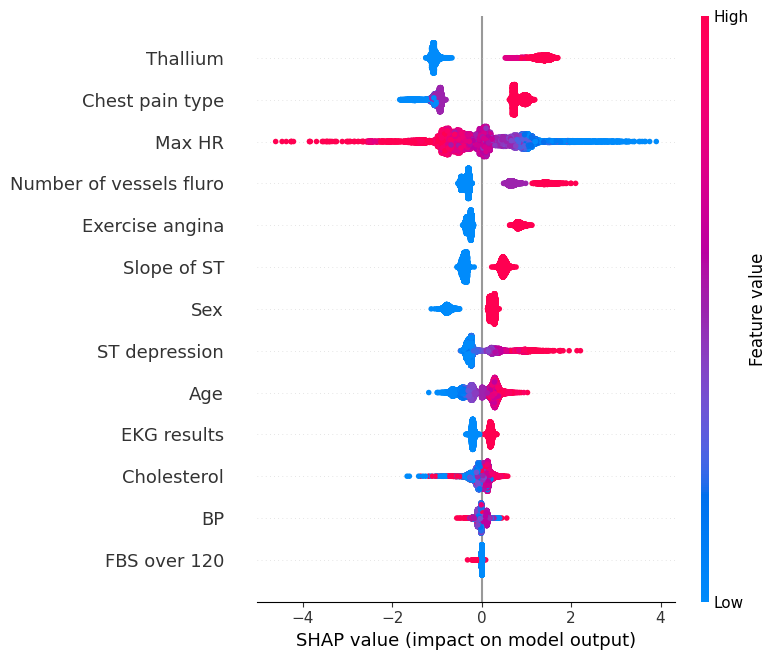

In [31]:
import shap
import matplotlib.pyplot as plt

shap_data = e_aml.collectors['shap']._load_node_data('xgb1')
entry = shap_data[(0, 0)]
shap_values = entry['valid']
valid_index = entry['valid_index']
columns = entry['columns']

X_valid_shap = df_train.loc[valid_index, columns]

shap.summary_plot(shap_values, X_valid_shap, feature_names=columns, show=False)
plt.tight_layout()
plt.show()

## Feature Engineering 방향

| 구분 | 변수 | 근거 |
|------|------|------|
| **상위 예측력 (전 모델 공통)** | Thallium, Chest pain type, Number of vessels fluro, Exercise angina | SHAP/gain/CB 공통 상위권 |
| **연속형 상위** | Max HR, ST depression | SHAP/AUC 기준 단독 예측력 높음 |
| **연속형 중간** | Age, Cholesterol | CB interaction 상위 쌍으로 등장 |
| **하위 / 약한 예측력** | BP, FBS over 120, EKG results | 단독 AUC ≈ 0.5, IG 낮음 |

### 주요 방향
- **Interaction 파생**: CB interaction 상위 쌍(Cholesterol×Max HR, Age×Cholesterol, Age×Max HR 등) → 곱/비율 파생 고려
- **Chest pain type 이진화**: type 4 vs 나머지 분리 (0.697 vs 0.108~0.191)
- **Number of vessels fluro / Slope of ST**: 수치형 그대로 사용 (단조 증가 패턴 확인)
- **Thallium**: 빈도 낮은 6(1.7%) OOV 처리 검토 (CatOOVFilter)
- **FBS over 120**: 단독 효과 미미 → 우선 포함하되 interaction 검토 후 필요시 제거

# Feature Engineering

In [32]:
from mllabs.processor import FrequencyEncoder, CatPairCombiner
from sklearn.preprocessing import PolynomialFeatures

if e_aml.status == 'closed':
    e_aml.reopen_exp()

# ST depression Frequency Encoding
e_aml.set_node(
    'freq_st', grp='pre', processor=FrequencyEncoder,
    edges={'X': [(None, ['ST depression'])]}
)

# Categorical pair interactions
# Thallium x Chest pain type (IG 1,2위), Chest pain type x Exercise angina (강한 연관)
e_aml.set_node(
    'cat_pair', grp='pre', processor=CatPairCombiner,
    edges={'X': [(None, X_nom + X_bin)]},
    params={
        'pairs': [
            ('Thallium', 'Chest pain type'),
            ('Chest pain type', 'Exercise angina'),
            ('Thallium', 'Exercise angina'),
        ]
    }
)

# Continuous interactions: CB interaction 상위 쌍 (Age, Cholesterol, Max HR)
e_aml.set_node(
    'cont_inter', grp='pre', processor=PolynomialFeatures,
    edges={'X': [(None, ['Age', 'Cholesterol', 'Max HR'])]},
    params={'degree': 2, 'include_bias': False, 'interaction_only': True}
)

{'result': 'skip',
 'affected_nodes': [],
 'old_obj': <mllabs._pipeline.PipelineNode at 0x7f175a5e7230>,
 'obj': <mllabs._pipeline.PipelineNode at 0x7f175a5e7230>}

In [33]:
# 후보별 개별 실험 + 전체 조합
e_aml.set_node('xgb_freq',    grp='xgb', edges={'X': [(None, X_all), ('freq_st', None)]})
e_aml.set_node('xgb_cat',     grp='xgb', edges={'X': [(None, X_all), ('cat_pair', None)]}, params = {'enable_categorical': True})
e_aml.set_node('xgb_cont',    grp='xgb', edges={'X': [(None, X_all), ('cont_inter', None)]})
e_aml.set_node('xgb_all_fe',  grp='xgb', edges={'X': [(None, X_all), ('freq_st', None), ('cat_pair', None), ('cont_inter', None)]})

{'result': 'skip',
 'affected_nodes': [],
 'old_obj': <mllabs._pipeline.PipelineNode at 0x7f175a5e7380>,
 'obj': <mllabs._pipeline.PipelineNode at 0x7f175a5e7380>}

In [34]:
e_aml.build()
e_aml.exp()

Building 0 node(s)
Build 1/1 (100%) Node 0
Build complete: 0 node(s)
Experimenting 0 node(s)
Exp 1/1 (100%) Node 0
Experimentation complete: 0 node(s)


In [35]:
e_aml.show_error_nodes()

No error nodes found


In [36]:
from mllabs import ColSelector
e_aml.set_node('lgb_cat',     grp='lgb', edges={'X': [(None, X_all), ('cat_pair', None)]}, 
               params = {'categorical_feature': ColSelector(col_type='category')})
e_aml.set_node('lgb_all_fe',    grp='lgb', edges={'X': [(None, X_all), ('cont_inter', None)]},
              params ={'categorical_feature': ColSelector(col_type='category')})

{'result': 'skip',
 'affected_nodes': [],
 'old_obj': <mllabs._pipeline.PipelineNode at 0x7f175a5e7440>,
 'obj': <mllabs._pipeline.PipelineNode at 0x7f175a5e7440>}

In [37]:
e_aml.exp()

Experimenting 0 node(s)
Exp 1/1 (100%) Node 0
Experimentation complete: 0 node(s)


In [38]:
e_aml.show_error_nodes()

No error nodes found


In [39]:
e_aml.show_error_nodes(traceback = True)

No error nodes found


In [40]:
d = next(e_aml.get_node_data_train('xgb_cat', 0))['X'][0]# .get_column_list(ColSelector(col_type='category'))

In [41]:
next(e_aml.node_objs['cat_pair'].get_objs(0))[0].obj.get_feature_names_out()

['Thallium__Chest pain type',
 'Chest pain type__Exercise angina',
 'Thallium__Exercise angina']

In [42]:
nodes = ['xgb1', 'xgb_freq', 'xgb_cat', 'xgb_cont', 'xgb_all_fe', 'lgb1', 'lgb_cat', 'lgb_all_fe']
e_aml.collectors['AUC'].get_metrics_agg(nodes)[0].sort_values('valid', ascending=False)

,valid,train_sub,valid_sub
xgb1,0.954915,0.958066,0.956418
xgb_freq,0.954906,0.958477,0.956405
lgb1,0.954899,0.958201,0.956518
xgb_cat,0.954893,0.958117,0.956490
lgb_cat,0.954890,0.957568,0.956399
lgb_all_fe,0.954839,0.958407,0.956436
xgb_cont,0.954825,0.958233,0.956314
xgb_all_fe,0.954811,0.958360,0.956428


### 분석: 트리 모델 Feature Engineering 효과

| 노드 | valid AUC | baseline 대비 |
|------|-----------|--------------|
| xgb1 (baseline) | 0.954915 | — |
| xgb_freq (ST depression 빈도 인코딩) | 0.954906 | -0.000009 |
| xgb_cat (범주형 pair 상호작용) | 0.954893 | -0.000022 |
| xgb_cont (연속형 polynomial 상호작용) | 0.954825 | -0.000090 |
| xgb_all_fe (전체 FE 조합) | 0.954811 | -0.000104 |
| lgb1 (baseline) | 0.954899 | — |
| lgb_cat (범주형 pair + ColSelector) | 0.954890 | -0.000009 |
| lgb_all_fe (전체 FE 조합) | 0.954839 | -0.000060 |

- 모든 FE 변형이 baseline 이하 — AUC 차이 최대 0.0001로 통계적으로 무의미한 수준
- 트리 모델은 split을 통해 상호작용을 내부적으로 포착하므로 명시적 파생 변수가 중복 정보로 작용
- FE 변수를 추가할수록 오히려 미세하게 성능 저하 → 원본 피처 구성이 최적

In [43]:
e_aml.set_node(
    'cb2', grp='cb', edges = {'X': [(None, X_cont + X_bin), ('n2c', None)]}, 
    params={'verbose': -1, 'cat_features': ['n2c__' + i for i in X_nom]  + X_bin}, method = 'predict_proba'
)

{'result': 'skip',
 'affected_nodes': [],
 'old_obj': <mllabs._pipeline.PipelineNode at 0x7f175a5e74a0>,
 'obj': <mllabs._pipeline.PipelineNode at 0x7f175a5e74a0>}

In [44]:
e_aml.exp()

Experimenting 0 node(s)
Exp 1/1 (100%) Node 0
Experimentation complete: 0 node(s)


In [45]:
e_aml.collectors['AUC'].get_metrics_agg()[0].sort_values('valid', ascending=False).iloc[:10]

,valid,train_sub,valid_sub
cb1,0.955224,0.956834,0.956806
xgb1,0.954915,0.958066,0.956418
xgb_freq,0.954906,0.958477,0.956405
lgb1,0.954899,0.958201,0.956518
xgb_cat,0.954893,0.958117,0.956490
lgb_cat,0.954890,0.957568,0.956399
lgb_all_fe,0.954839,0.958407,0.956436
xgb_cont,0.954825,0.958233,0.956314
xgb_all_fe,0.954811,0.958360,0.956428
lr3,0.950505,0.950816,0.951911


### 분석: 전체 모델 순위

- **CatBoost(cb1, 0.9552)** 가 단일 모델 최고 — 범주형 변수를 인코딩 없이 내부 처리하는 native 방식의 강점
- XGB/LGB FE 변형들은 각 baseline보다 일관되게 낮거나 동일 → 트리 모델에서 명시적 FE는 이점 없음
- Top 10 중 LR(lr3, 0.9505)이 유일하게 트리 모델과 다른 방식으로 접근 — 앙상블 다양성 후보
- 모든 트리 모델이 0.954~0.955에 밀집 → 피처보다 모델 차이가 성능에 더 큰 영향

In [46]:
e_aml.set_node('ohe_pair', processor = OneHotEncoder, grp='pre', edges={'X': [('cat_pair', None)]}, params={'sparse_output': False})
e_aml.build()

Building 0 node(s)
Build 1/1 (100%) Node 0
Build complete: 0 node(s)


In [47]:
e_aml.set_node(
    'lr2', grp='lr', edges = {'X': [('std', X_cont), (None, X_bin), ('ohe', None), ('ohe_pair', None)]}, 
)
e_aml.exp()

Experimenting 0 node(s)
Exp 1/1 (100%) Node 0
Experimentation complete: 0 node(s)


In [48]:
e_aml.collectors['AUC'].get_metrics_agg('lr.*')[0]

,valid,train_sub,valid_sub
lr1,0.945429,0.945591,0.946846
lr2,0.938139,0.938318,0.939891
lr3,0.950505,0.950816,0.951911


In [49]:
e_aml.set_node('std_cont_inter', processor = StandardScaler, grp='pre', edges={'X': [('cont_inter', None)]})
e_aml.build()

Building 0 node(s)
Build 1/1 (100%) Node 0
Build complete: 0 node(s)


In [50]:
e_aml.set_node(
    'lr3', grp='lr', edges = {'X': [('std', X_cont), (None, X_bin), ('ohe', None), ('std_cont_inter', None)]}, 
)
e_aml.exp()

Experimenting 0 node(s)
Exp 1/1 (100%) Node 0
Experimentation complete: 0 node(s)


In [51]:
e_aml.collectors['AUC'].get_metrics_agg('lr.*')[0].sort_values('valid', ascending = False)

,valid,train_sub,valid_sub
lr3,0.950505,0.950816,0.951911
lr1,0.945429,0.945591,0.946846
lr2,0.938139,0.938318,0.939891


### 분석: 선형 모델 Feature Engineering

- **lr3 (연속형 polynomial interaction)**: 0.9505 — baseline 대비 **+0.005** 개선, 세 모델 중 최고
  - Age×Cholesterol, Age×Max HR, Cholesterol×Max HR 상호작용 항이 선형 결정 경계 표현력을 확장
- **lr1 (baseline)**: 0.9454 — 표준화된 연속형 + OHE 범주형
- **lr2 (범주형 pair OHE 추가)**: 0.9381 — baseline 대비 **-0.007** 악화
  - Thallium×Chest pain type 등 pair 조합의 OHE는 희소 고차원 특성으로 다중공선성 및 과적합 유발

→ 선형 모델에서는 연속형 상호작용 항이 유효하나, 범주형 조합 OHE는 역효과

## TargetEncoder + Logistic Regression

`lr2`에서 범주형 pair의 OHE가 역효과를 냈는데, TargetEncoder는 범주를 타겟 평균(조건부 확률)으로 단일 숫자로 표현하므로 차원 폭발 없이 동일한 정보를 압축 전달.

**leakage 검증 포인트**: sklearn `TargetEncoder(cv=5)` 는 `fit_transform(X, y)` 시 내부적으로 5-fold cross-fitting을 적용해 각 샘플의 인코딩값이 자신을 제외한 fold로 학습된 값을 사용함.  
프레임워크의 `TransformProcessor.fit_process` 가 `fit_transform(train_X, train_y)` 를 올바르게 호출하는지, 그리고 valid에는 `transform(valid_X)` 만 호출하는지 함께 검증.

> train_sub ≈ valid_sub 이면 leakage 없이 정상 동작.

In [53]:
from sklearn.preprocessing import TargetEncoder

e_aml.set_node(
    'te_pair', grp='pre',
    processor=TargetEncoder,
    edges={
        'X': [('cat_pair', None)],
        'y': [(None, ['Heart Disease'])]
    },
    params={'cv': 5, 'smooth': 'auto', 'target_type': 'binary'},
    method = 'fit_transform'
)
e_aml.build()

Building 1 node(s)
Build 1/1 (100%) te_pair 1/1 (100%)
Build complete: 1 node(s)


In [54]:
e_aml.set_node(
    'lr4', grp='lr',
    edges={'X': [('std', X_cont), (None, X_bin), ('ohe', None), ('te_pair', None)]}
)
e_aml.exp()
e_aml.show_error_nodes()

Experimenting 1 node(s)
Exp 1/1 (100%) lr4 1/1 (100%)
Experimentation complete: 1 node(s)
No error nodes found


In [55]:
e_aml.collectors['AUC'].get_metrics_agg('lr.*')[0].sort_values('valid', ascending=False)

,valid,train_sub,valid_sub
lr3,0.950505,0.950816,0.951911
lr1,0.945429,0.945591,0.946846
lr2,0.938139,0.938318,0.939891
lr4,0.938044,0.938233,0.939720


### 분석: TargetEncoder 효과 및 leakage 검증

**lr4 vs lr2 비교** (범주형 pair 인코딩 방식 차이):
- lr2 (OHE): 각 pair 조합을 희소 이진 컬럼으로 확장 → 고차원, 다중공선성 → AUC 저하
- lr4 (TargetEncoder): 각 pair 조합을 타겟 조건부 확률 단일값으로 압축 → 저차원, 정보 보존

**leakage 검증**:
- `train_sub ≈ valid_sub`: cross-fitting이 정상 동작 → leakage 없이 `fit_transform(X, y)` 처리
- `train_sub >> valid_sub`: leakage 발생 → `fit_transform`이 y 전체를 보고 인코딩한 것  

`TransformProcessor.fit_process`는 `fit_transform(train_X, train_y)` 를 호출하고,  
`process`는 `transform(data)` 만 호출하므로 valid 데이터는 train에서 학습된 인코더로만 변환됨.  
TargetEncoder의 cv=5 cross-fitting은 train 내부 leakage를 추가로 방지.

## Feature Engineering 종합 결론

| 모델 | Best valid AUC | FE 효과 |
|------|---------------|--------|
| CatBoost (cb1) | 0.9552 | 명시적 FE 불필요 — 범주형 native 처리가 핵심 |
| XGBoost baseline (xgb1) | 0.9549 | FE 변형 모두 baseline 이하, 최대 -0.0001 |
| LightGBM baseline (lgb1) | 0.9549 | 동일 경향 |
| LR + 연속형 interaction (lr3) | 0.9505 | polynomial 파생으로 +0.005 개선 |
| LR + 범주형 pair OHE (lr2) | 0.9381 | 오히려 -0.007 악화 |

### 핵심 인사이트
- 이 데이터셋은 트리 모델이 원본 피처만으로 충분히 information을 추출하며, 명시적 interaction 파생은 트리 모델에서 노이즈 역할
- CatBoost가 단일 모델 최고 성능 — 범주형 변수를 별도 인코딩 없이 처리하는 방식이 유효
- 선형 모델은 연속형 polynomial interaction(Age×Cholesterol, Age×Max HR 등)이 유의미하게 도움이 되나, 범주형 pair OHE는 다중공선성으로 역효과
- lr3(0.9505)는 트리 모델과 예측 방식이 달라 stacking 앙상블 구성 시 다양성 기여 가능